# Interpret the static locations

In [1]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

/home/jovyan/ml_drought


In [2]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [3]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [4]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [5]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [6]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [7]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

# bline_pred = read_pred_data('previous_month', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
# lstm_pred = read_pred_data('rnn', data_dir, experiment=EXPERIMENT)[-1].where(~mask)
ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

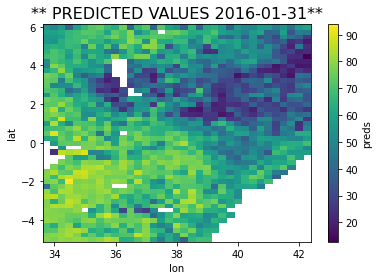

In [8]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [9]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

# check the static data

In [10]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

N Vars: 29


<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    precip_global_mean                          (lat, lon) float64 ...
    E_global_mean                               (lat, lon) float64 ...
    SMroot_global_mean                          (lat, lon) float64 ...
    SMsurf_global_mean                          (lat, lon) float64 ...
    pev_global_mean                             (lat, lon) float64 ...
    t2m_global_mean                             (lat, lon) float64 ...
    precip_pixel_mean                           (lat, lon) float64 ...
    E_pixel_mean                                (lat, lon) float64 ...
    SMroot_pixel_mean                           (lat, lon) float64 ...
    SMsurf_pixel_mean                           (lat, lon) float64 ...
    pev_pixel_mean                              (lat, lon) float64 ...
    t2m_pixel_mean                              (lat, lon) float64 ...
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

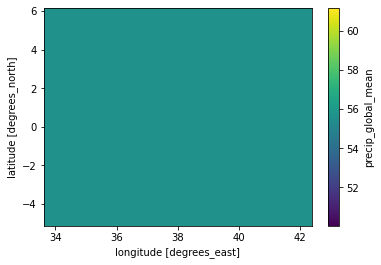

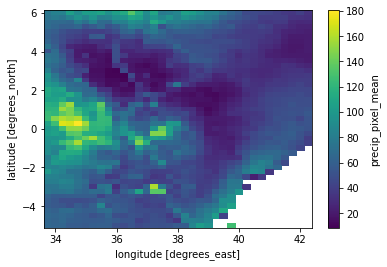

In [11]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# 1. Create static Embeddings

In [12]:
plt.cm

<module 'matplotlib.cm' from '/opt/conda/lib/python3.7/site-packages/matplotlib/cm.py'>

In [13]:
from typing import Tuple


def sigmoid(x):
    return 1/(1 + np.exp(-x))


def build_static_x(x: Tuple[np.array], ) -> Tuple[List[np.array], List[np.array], List[np.array]]:
    all_static_x = []
    all_latlons = []
    all_pred_months = []

    for i in range(len(x)):  # EACH BATCH (of X,y pairs)
        pred_month_data = x[i][1]
        latlons_data = x[i][2]
        yearly_aggs_data = x[i][4]
        static_data = x[i][5]
        assert static_data.shape[-1] == 29, f"{static_data.shape}"
        # print()
        # print("pred_month_data.shape", (pred_month_data.shape[0], 12) if pred_month_data is not None else "None")
        # print("latlons_data.shape", latlons_data.shape if latlons_data is not None else "None")
        # print("yearly_aggs_data.shape", yearly_aggs_data.shape if yearly_aggs_data is not None else "None")
        # print("static_data.shape", static_data.shape if static_data is not None else "None")
        # break
        
        # append the static_arrays
        static_x = []
        # normalise latlon
        static_x.append((latlons_data - latlons_data.mean(axis=0)) / latlons_data.std(axis=0))  # 0, 1
        static_x.append(yearly_aggs_data)  # 2: 9
        static_x.append(static_data)
        # one_hot_encode the pred_month_data
        try:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).numpy())
        except TypeError:
            static_x.append(ealstm._one_hot(torch.from_numpy(pred_month_data), 12).cpu().numpy())
        
        # exclude Nones
        static_x = np.concatenate([x for x in static_x if x is not None], axis=-1)
        # print("Static X Data Shape: ", static_x.shape)
        
        # all data
        all_static_x.append(static_x)

        # metadata (latlons and pred_months)
        all_latlons.append(latlons_data)
        all_pred_months.append(pred_month_data)
        
    return all_static_x, all_latlons, all_pred_months


def calculate_embeddings(static_x: np.ndarray, W: np.ndarray, b: np.array) -> np.array:
    assert W.T.shape[0] == static_x.shape[-1], f"Matrix operations must be valid {static_x.shape} * {W.T.shape}"
    
    embedding = []
    for pixel_ix in range(static_x.shape[0]):
        embedding.append(sigmoid(np.dot(W, static_x[pixel_ix]) + b))
    return np.array(embedding)


def get_train_mask(ealstm):
    val_split = 0.1
    len_mask = len(
        DataLoader._load_datasets(
            ealstm.data_path,
            mode="train",
            experiment=EXPERIMENT,
            shuffle_data=False,
            pred_months=None,
        )
    )
    train_mask, val_mask = train_val_mask(len_mask, val_split)
    return train_mask


def get_static_embedding(ealstm) -> Tuple[List[np.array], Tuple[List[np.array], np.array, List[np.array]]]:
    # get W, b from state_dict
    od = ealstm.model.static_embedding.state_dict()
    try:
        W = od['weight'].numpy()
        b = od['bias'].numpy()
    except TypeError:
        W = od['weight'].cpu().numpy()
        b = od['bias'].cpu().numpy()
        
    # get X_static data from dataloader
    print("Calling Training DataLoader")
    dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
    x = [x for (x, y) in dl]
        
    # build static_x matrix
    all_static_x, all_latlons, all_pred_months = build_static_x(x)
    # check w^Tx + b is a valid matrix operation
    assert W.T.shape[0] == all_static_x[0].shape[-1], f"W.T shape: {W.T.shape} static_x shape: {all_static_x[0].shape}"
    
    # calculate the embeddings
    all_embeddings = []
    for static_x in all_static_x:
        embedding = calculate_embeddings(static_x, W=W, b=b)
        all_embeddings.append(embedding)
        
    return all_embeddings, (all_static_x, np.array(all_latlons), np.array(all_pred_months))

### Load the static embeddings and check for errors

In [14]:
all_e, (all_static_x, all_latlons, all_pred_months) = get_static_embedding(ealstm=ealstm)

Calling Training DataLoader
data/features/one_month_forecast/train/2002_3 returns no values. Skipping
data/features/one_month_forecast/train/2002_4 returns no values. Skipping


In [15]:
pred_months_err_mask = [len(np.unique(pm)) == 1 for pm in all_pred_months]
all_e = np.array(all_e)[pred_months_err_mask]
all_static_x = np.array(all_static_x)[pred_months_err_mask]
all_pred_months = np.array(all_pred_months)[pred_months_err_mask]
all_latlons = np.array(all_latlons)[pred_months_err_mask]

assert all_latlons.shape == all_static_x.shape
assert all_pred_months.shape == all_e.shape

# assert all timsteps have only 1 pred month
assert all([i == 1 for i in [len(np.unique(pm)) for pm in all_pred_months]])

In [16]:
def sort_by_another_list(list_to_sort, list_to_sort_on):
    assert len(list_to_sort) == len(list_to_sort_on)
    sort_ixs = np.argsort(list_to_sort_on)
    return list_to_sort[sort_ixs]


# SORTBY month
pred_months = [int(np.unique(pm)) for pm in all_pred_months]

all_e = sort_by_another_list(all_e, pred_months)
all_static_x = sort_by_another_list(all_static_x, pred_months)
all_latlons = sort_by_another_list(all_latlons, pred_months)
all_pred_months = sort_by_another_list(all_pred_months, pred_months)

pred_months = [int(np.unique(pm)) for pm in all_pred_months]
pred_months

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 3,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 5,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 6,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 7,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 8,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 9,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 10,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 11,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12,
 12]

### Check that really static

In [17]:
import calendar
# get the unique indexes of the months (from pred_months)
unique_ids = [pred_months.index(x) for x in set(pred_months)]

# check the first for that month against the others for that month
for id_1, id_2, month in zip(unique_ids, [id_ + 1 for id_ in unique_ids], set(pred_months)):
    mth = calendar.month_abbr[month]
    if all_e[id_1].shape == all_e[id_2].shape:
        print(f"1 {mth}: ", np.all(all_e[id_1] == all_e[id_2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 1].shape:
        print(f"2 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 1]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 2].shape:
        print(f"3 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 2]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 3].shape:
        print(f"4 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 3]))
    elif all_e[id_1 + 1].shape == all_e[id_2 + 4].shape:
        print(f"5 {mth}: ", np.all(all_e[id_1 + 1] == all_e[id_2 + 4]))
    else:
        print(f"# {mth}: UNABLE TO FIND matching shape")

# Jan: UNABLE TO FIND matching shape
2 Feb:  False
# Mar: UNABLE TO FIND matching shape
2 Apr:  False
1 May:  True
3 Jun:  False
2 Jul:  True
1 Aug:  True
5 Sep:  False
2 Oct:  True
2 Nov:  True
1 Dec:  True


### get the monthly data

In [18]:
unique_ids = [pred_months.index(x) for x in set(pred_months)]

month_embeddings = all_e[unique_ids]
month_static_x = all_static_x[unique_ids]
month_latlons = all_latlons[unique_ids]
month_pred_months = all_pred_months[unique_ids]
month_pred_months = [np.unique(m)[0] for m in month_pred_months]

In [19]:
### Plot the matrices

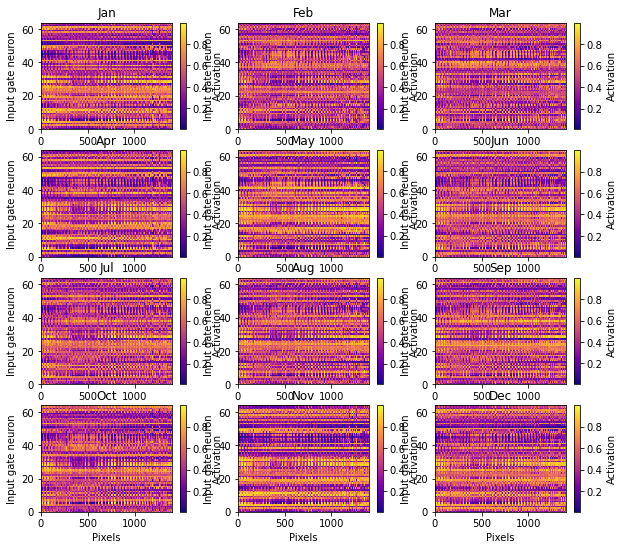

In [20]:
import calendar

fig, axs = plt.subplots(4, 3, figsize=(10, 3*3))
for ix, (embedding, pred_month) in enumerate(zip(month_embeddings, month_pred_months)):
    ax = axs[np.unravel_index(ix, (4, 3))]
    img = ax.pcolor(embedding.T, cmap='plasma')
    ax.set_xlabel("Pixels")
    ax.set_ylabel("Input gate neuron")
    month = [m for m in calendar.month_abbr][pred_month]
    ax.set_title(f"{month}")
    cbar = plt.colorbar(img, ax=ax)
    cbar.ax.set_ylabel("Activation")

# 2. Cluster the static embeddings

In [21]:
from collections import defaultdict
from typing import List, Dict, Union
from sklearn.cluster import KMeans


def fit_kmeans(
    array: np.array, 
    ks: List[int] = [4],
    init_array: Optional[np.ndarray] = None,
) -> Dict[int, Dict[int, int]]:
    # initialise the output dictionary
    clusters = {k: {} for k in ks}
    
    for k in ks:
        if init_array is not None:
            assert init_array.shape[0] == k, "First dimension should be "
            clusterer = KMeans(
                n_clusters=k, random_state=0, init=init_array, n_init=1
            ).fit(array)
        else:
            clusterer = KMeans(
                n_clusters=k, random_state=0, init='k-means++', n_init=200
            ).fit(array)

        for pixel in range(array.shape[0]):
            arr = array[pixel, :]
            clusters[k][pixel] = clusterer.predict(arr.reshape(1, -1))[0]
    return clusters


def convert_clusters_to_ds(ks: List[int], static_clusters: Dict[int, np.array], pixels: np.ndarray, latitudes: np.ndarray, longitudes: np.ndarray, time: Union[pd.Timestamp, int] = 1) -> xr.Dataset:
    out = []
    for k in ks:
        cluster = np.array([v for v in static_clusters[k].values()])
        coords = {'pixel': pixels}
        dims = ['pixel']
        cluster_ds = xr.Dataset(
            {
                f'cluster_{k}': (dims, cluster), 
                'lat': (dims, latitudes), 
                'lon': (dims, longitudes), 
                'time': (dims, [time for _ in range(len(latitudes))]),
            }
        )
        out.append(cluster_ds)
    
    static_cluster_ds = xr.auto_combine(out)
    static_cluster_ds = static_cluster_ds.to_dataframe().set_index(['time', 'lat','lon']).to_xarray()
    
    return static_cluster_ds


def plot_cluster_ds(ks: List[int], static_cluster_ds: xr.Dataset, cmap=None, month_abbr: str = ''):
    for k in ks:
        fig, ax = plt.subplots(figsize=(12,8))
        static_cluster_ds[f'cluster_{k}'].plot(ax=ax, cmap=cmap)
        ax.set_title(f'Output of Static Embedding Clustering [k={k}]\n{month_abbr}');

        for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]): # + ax.get_xticklabels() + ax.get_yticklabels()):
            item.set_fontsize(20)

In [22]:
# calculate clusters for ALL x.nc inputs
all_cluster_ds = []

for ix, (embedding, pred_month, latlons) in enumerate(zip(
    month_embeddings, 
    month_pred_months, 
    month_latlons
)):
    ks = [5]
    # fit the clusters
    static_clusters = fit_kmeans(embedding, ks)
    print(f"Fitted KMeans {ix}") if ix % 10 == 0 else None
    
    # convert to dataset
    pixels = latlons
    lons = latlons[:, 1] 
    lats = latlons[:, 0] 
    static_cluster_ds = convert_clusters_to_ds(ks, static_clusters, pixels, lats, lons, time=ix)
    print(f"Convert to ds {ix}") if ix % 10 == 0 else None
    
    # append to final list
    all_cluster_ds.append(static_cluster_ds)

# combine into one xr.Dataset
cluster_ds = xr.auto_combine(all_cluster_ds)

Fitted KMeans 0
Convert to ds 0
Fitted KMeans 10
Convert to ds 10


In [23]:
cluster_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

# 3. Plot / Group the static embeddings

dict_values([0.0, 4.0, 1.0, 3.0, 2.0])


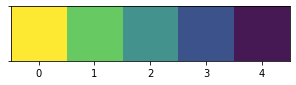

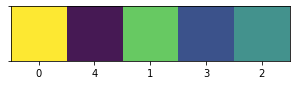

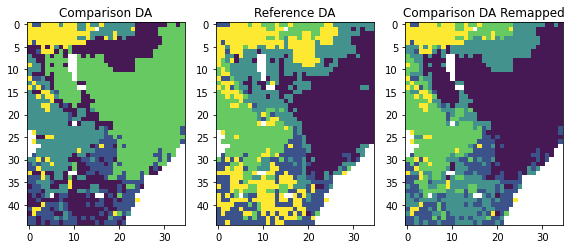

In [24]:
from matplotlib.colors import ListedColormap
from src.utils import Region
from src.preprocess.utils import select_bounding_box

# ---------------------------------------------------------------------------
# Parameters for running the functions
# ---------------------------------------------------------------------------
#                   yellow,    green,    turqoise,   blue,      purple
colors = np.array(['#fde832', '#67c962', '#43928d', '#3b528b', '#461954'])
cmap = ListedColormap(colors)

kitui = Region(
    name='kitui',
    lonmin=cluster_ds.isel(lon=13).lon.values,
    lonmax=cluster_ds.isel(lon=19).lon.values,
    latmin=cluster_ds.isel(lat=-34).lat.values,
    latmax=cluster_ds.isel(lat=-24).lat.values,
)
victoria = Region(
    name='victoria',
    lonmin=cluster_ds.isel(lon=0).lon.values,
    lonmax=cluster_ds.isel(lon=12).lon.values,
    latmin=cluster_ds.isel(lat=-31).lat.values,
    latmax=cluster_ds.isel(lat=-15).lat.values,
)
turkana_edge = Region(
    name='turkana_edge',
    lonmin=cluster_ds.isel(lon=14).lon.values,
    lonmax=cluster_ds.isel(lon=29).lon.values,
    latmin=cluster_ds.isel(lat=-9).lat.values,
    latmax=cluster_ds.isel(lat=-2).lat.values,
)
nw_pastoral = Region(
    name='nw_pastoral',
    lonmin=cluster_ds.isel(lon=0).lon.values,
    lonmax=cluster_ds.isel(lon=12).lon.values,
    latmin=cluster_ds.isel(lat=-6).lat.values,
    latmax=cluster_ds.isel(lat=-1).lat.values,
)
coastal = Region(
    name='coastal',
    lonmin=cluster_ds.isel(lon=21).lon.values,
    lonmax=cluster_ds.isel(lon=34).lon.values,
    latmin=cluster_ds.isel(lat=-25).lat.values,
    latmax=cluster_ds.isel(lat=-13).lat.values,
)

regions = [
    coastal,
    victoria,
    nw_pastoral,
    kitui,
    turkana_edge,
]

# ---------------------------------------------------------------------------
# Functions
# ---------------------------------------------------------------------------

def get_matching_groups(
    reference_ds: xr.DataArray, comparison_ds: xr.DataArray,
    percent: bool = True, regions: Optional[List[Region]] = None,
) -> Tuple[Dict[float, float], pd.DataFrame]:
    # get the unique values from the reference_ds
    group_vals = np.unique(reference_ds.values[~np.isnan(reference_ds.values)])
    
    if regions is not None:
        df = count_mappings_for_regions(reference_ds, comparison_ds, regions)
        remap_dict = match_by_region_algorithm(df, regions)
        
    else:
        # calculate the number of matching pixels
        df = convert_counts_dict_to_dataframe(
            count_matching_pixels(reference_ds, comparison_ds)
        )

        # calculate_the remap_dict
        remap_dict = most_overlapping_pixels_algorithm(df, percent=percent)

    # check that the groups are matching / all groups are included
    assert all(np.isin(np.unique(df['reference_group'].values), group_vals))
    assert all(np.isin(np.unique(df['comparison_group'].values), group_vals))

    # check all values in group_vals are in the dict keys
    assert all(np.isin([k for k in remap_dict.keys()], group_vals))

    return remap_dict, df


def count_matching_pixels(reference_ds: xr.Dataset, comparison_ds: xr.Dataset) -> Dict[float, Dict[float, float]]:
    """Count the number of pixels for each value
        in comparison_ds for each reference value
        in reference_ds

    Returns:
    -------
     Dict[float, Dict[float, float]]
        keys = reference_ds values "group_0"
        values = {comparison_ds values: count of matches} "group_1"
    """
    unique_counts = dict()

    # for each reference value in reference_ds
    # excluding np.nan
    for value in np.unique(reference_ds.values[~np.isnan(reference_ds.values)]):
        # get the pixels from Comparison corresponding to `value` in Reference
        np_arr = comparison_ds.where(reference_ds == value).values
        # drop nans from matching values
        np_arr = np_arr[~np.isnan(np_arr)]
        # calculate the number of group_1 pixels
        counts = np.unique(np_arr, return_counts=True)
        unique_counts[value] = dict(zip(counts[0], counts[1]))

    return unique_counts


def convert_counts_dict_to_dataframe(unique_counts: dict) -> pd.DataFrame:
    """create long format dataframe from counts in unique_counts
    reference_ds = group_0
    comparison_ds = group_1
    """
    df = pd.DataFrame(unique_counts)  # rows = group_1_values, cols = group_0_values
    df.columns = df.columns.rename('reference_group')
    df.index = df.index.rename('comparison_group')
    # 2D -> 1D idx, group_0, group_1, count
    df = df.unstack().reset_index().rename(columns={0:'count'})

    counts = df.groupby('comparison_group')['count'].sum()
    df['pct'] = df.apply(lambda x: x['count'] / counts.loc[x['comparison_group']], axis=1)

    return df


def get_max_count_row(df: pd.DataFrame) -> pd.Series:
    """Get the row with the largest count from df"""
    return df.loc[df['count'].idxmax()]


def get_max_percent_row(df: pd.DataFrame) -> pd.Series:
    """Get the row with the highest percentage overlap"""
    return df.loc[df['pct'].idxmax()]


def coarsen_da(ds: xr.Dataset, rolling_size: int = 3) -> xr.Dataset:
    # return ds.coarsen(lat=5, lon=5).median()
    return ds.rolling(lat=rolling_size).median().rolling(lon=rolling_size).median()


def drop_already_assigned_values(
    df: pd.DataFrame,
    assigned_group_values: List[float],
) -> pd.DataFrame:
    """drop the values that have been assigned (added to the lists)
    """
    # remove the matches from group_1 / comparison_group
    df = df.loc[~np.isin(df['comparison_group'], assigned_group_values)]
    # remove the matches from group_0 / reference_group
    df = df.loc[~np.isin(df['reference_group'], assigned_group_values)]
    return df


def calculate_remap_dict(reference_group_list: List[float], comparison_group_list: List[float]) -> Dict[float, float]:
    """create dictionary object containing the mapping from reference_group -> comparison_group"""
    remap_dict = dict()
    # TODO: Tis assumption is not true it's not symmetrical
    # remap dict is symmetrical:
    # values in group_0->group_1 are the same mapping as group_1 -> group_0
    remap_dict.update(dict(zip(reference_group_list, comparison_group_list)))
    remap_dict.update(dict(zip(remap_dict.values(), remap_dict.keys())))

    # sort the remap_dict
    remap_dict = {k :remap_dict[k] for k in sorted(remap_dict)}

    return remap_dict


def most_overlapping_pixels_algorithm(df: pd.DataFrame, percent: bool = True) -> Dict[float, float]:
    """match the 'closest' group from reference_group_list in comparison_group_list"""
    
    assert all(
        np.isin(["reference_group", "comparison_group"], [c for c in df.columns])
    ), f"Need columns reference_group comparison_group. Found: {df.columns}"
    # get the counts of each pixel value/group (excl. nans) and select the most cross-overs (by percentages)
    # order is important so we do the BEST match first
    # get the largest first
    reference_group_list = []
    comparison_group_list = []

    # match each reference_group to closest matching comparison_group
    # track progress by removing the matches that have already been made
    # from the dataframe
    while df.shape[0] > 0:
        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(df['comparison_group'].unique()) == 1:
            # final value is itself
            # remap_dict[df['comparison_group'].unique()[0]] = df['comparison_group'].unique()[0]
            reference_group_list.append(df['comparison_group'].unique()[0])
            comparison_group_list.append(df['comparison_group'].unique()[0])
            df = drop_already_assigned_values(
                df, reference_group_list + comparison_group_list
            )

        else:
            # otherwise match to the closest remaining match (most overlapping pixels)
            max_count_row = get_max_percent_row(df) if percent else get_max_count_row(df)
            reference_group_list.append(
                max_count_row['reference_group']
            )
            comparison_group_list.append(
                max_count_row['comparison_group']
            )

            # drop_already_assigned_values
            df = drop_already_assigned_values(
                df, reference_group_list+comparison_group_list
            )

    remap_dict = calculate_remap_dict(reference_group_list, comparison_group_list)

    return remap_dict

# --------------------------
# Region Algorithm
# --------------------------

def count_mappings_for_regions(
    reference_ds: xr.DataArray, 
    comparison_ds: xr.DataArray, 
    regions: List[str],
) -> pd.DataFrame:
    all_df = []
    variable = reference_ds.name
    
    for region in regions:
        region_reference_ds = select_bounding_box(reference_ds.to_dataset(), region)[variable]
        region_comparison_ds = select_bounding_box(comparison_ds.to_dataset(), region)[variable]
        
        # count the pixels in each group
        d = convert_counts_dict_to_dataframe(
            count_matching_pixels(region_reference_ds, region_comparison_ds)
        )
        d['region'] = [region.name for _ in range(len(d))]
        all_df.append(d)

    all_df = pd.concat(all_df)
    
    return all_df


def match_by_region_algorithm(all_df: pd.DataFrame, regions: List[str]) -> Dict[float, float]:
    """ Use predefined Region objects to subset the spatial maps and
    run the maximum count algorithm to map the groupings for these specific
    areas across months!
    """
    assert all(
        np.isin(["reference_group", "comparison_group"], [c for c in all_df.columns])
    ), f"Need columns reference_group comparison_group. Found: {all_df.columns}"

    reference_group_list = []
    comparison_group_list = []

    for region in regions:
        region_name = region.name

        # IF only one group-value left, assign it to the final remaining group (itself)
        if len(all_df['comparison_group'].unique()) == 1:
            # final value is itself
            # remap_dict[df['comparison_group'].unique()[0]] = df['comparison_group'].unique()[0]
            reference_group_list.append(all_df['reference_group'].unique()[0])
            comparison_group_list.append(all_df['comparison_group'].unique()[0])
            all_df = drop_already_assigned_values(
                all_df, reference_group_list + comparison_group_list
            )
        else:
            region_df = all_df.query(f"region == '{region_name}'")

            max_count_row = get_max_count_row(region_df)

            # save the mapping
            reference_group_list.append(
                max_count_row['reference_group']
            )
            comparison_group_list.append(
                max_count_row['comparison_group']
            )

            # drop_already_assigned_values
            all_df = all_df.loc[~np.isin(all_df['comparison_group'], comparison_group_list)]
            all_df = all_df.loc[~np.isin(all_df['reference_group'], reference_group_list)]


    remap_dict = calculate_remap_dict(reference_group_list, comparison_group_list)

    return remap_dict


# Plotting helper functions
def plot_colors_remapping(colors, remap_dict) -> None:
    colors_remapped = [[int(v) for v in remap_dict.values()]]
    sns.palplot(colors)
    sns.palplot(colors_remapped)



def plot_comparisons(
    reference_da: xr.DataArray, comparison_da: xr.DataArray,
    colors: List[str], remapping_dict: Dict[int, int], 
    title: Optional[str] = None
) -> None:
    """check that the remapping is sensible"""
    # convert to numpy array
    remapping_list = np.array([int(k) for k in remap_dict.values()])
    
    # plot the colormaps 
    sns.palplot(colors)
    ax = plt.gca()
    ax.set_xticks([i for i in range(0, 5)])
    ax.set_xticklabels([i for i in range(0, 5)])
    if title is not None:
        ax.set_title(title)
    sns.palplot(np.array(colors)[remapping_list])
    ax = plt.gca()
    ax.set_xticks([i for i in range(0, 5)])
    ax.set_xticklabels(remapping_list)
    
    # create cmaps
    new_cmap = ListedColormap(colors[remapping_list])
    cmap = ListedColormap(colors)
    
    # plot the spatial patterns
    fig, axs = plt.subplots(1, 3, figsize=((6.4/2)*3, 4.8))
    axs[1].imshow(reference_da.values[::-1, :], cmap=cmap)
    axs[1].set_title('Reference DA')
    axs[0].imshow(comparison_da.values[::-1, :], cmap=cmap)
    axs[0].set_title('Comparison DA')
    axs[2].imshow(comparison_da.values[::-1, :], cmap=new_cmap)
    axs[2].set_title('Comparison DA Remapped')

# remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds)
jan = cluster_ds.isel(time=0).cluster_5
may = cluster_ds.isel(time=4).cluster_5

comparison_ds = may
reference_ds = jan

remap_dict, df = get_matching_groups(reference_ds, comparison_ds, regions=regions)
remap_dict.values()

print(remap_dict.values())

## CHECK that the remapping is sensible!
plot_comparisons(
    reference_ds, comparison_ds,
    colors=colors,
    remapping_dict=remap_dict,
    title=None
)

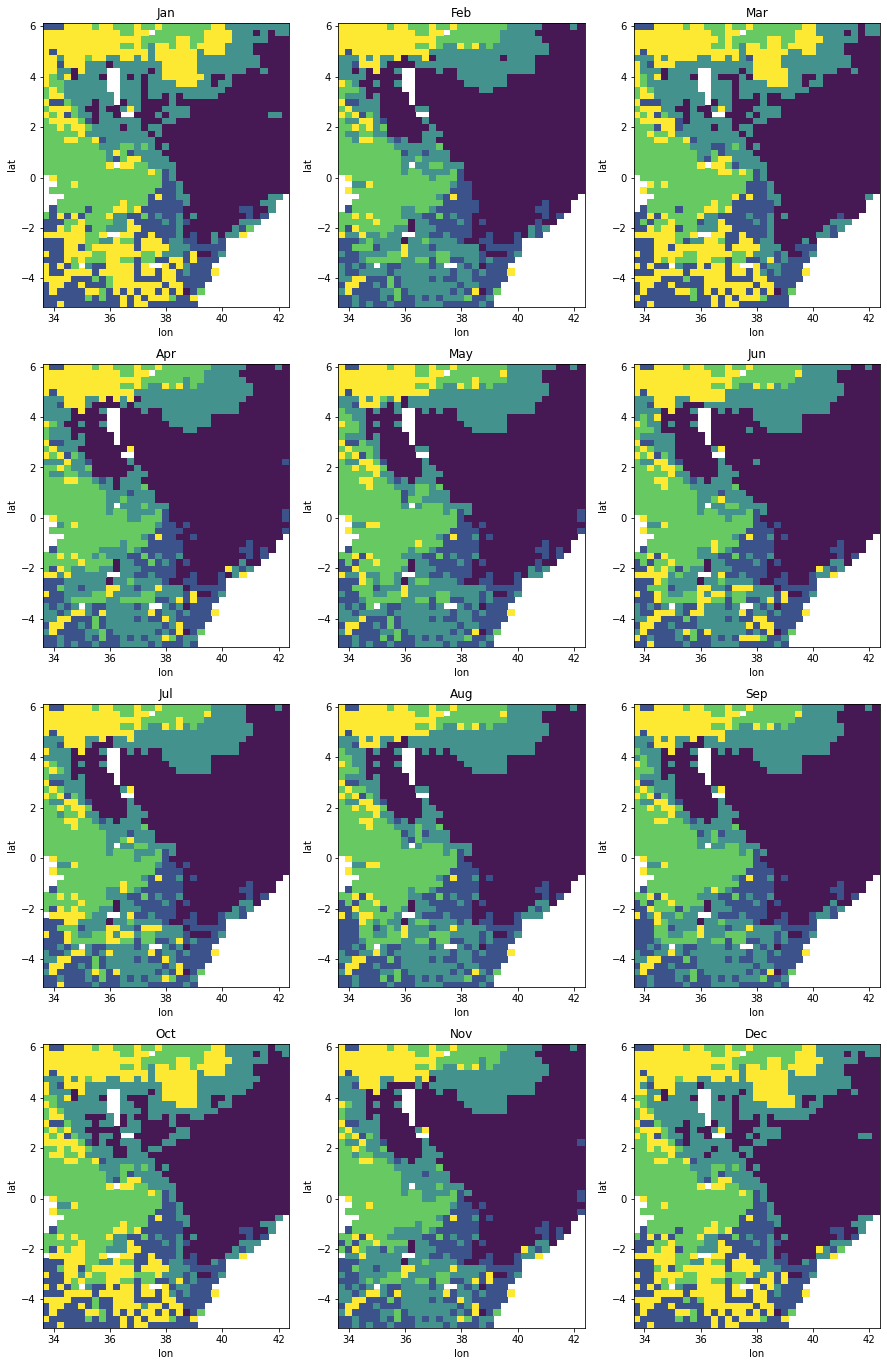

In [25]:
jan = cluster_ds.isel(time=0).cluster_5
reference_da = jan

fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))

cmap = ListedColormap(colors)
reference_da.plot(
    ax=axs[0, 0], add_colorbar=False, cmap=cmap
)
axs[0, 0].set_title(calendar.month_abbr[1])

remap_dicts = {}

for mth in range(1, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    comparison_ds = cluster_ds.isel(time=mth).cluster_5
    remap_dict, matches_df = get_matching_groups(reference_ds, comparison_ds, regions=regions)
    new_cmap = ListedColormap(colors[np.array([int(i) for i in remap_dict.values()])])
    comparison_ds.plot(
        add_colorbar=False, ax=ax, cmap=new_cmap
    )
    ax.set_title(calendar.month_abbr[mth+1])
    remap_dicts[calendar.month_abbr[mth+1]] = remap_dict

In [26]:
remap_dicts

{'Feb': {0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 0.0},
 'Mar': {0.0: 0.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0, 4.0: 4.0},
 'Apr': {0.0: 4.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0, 4.0: 0.0},
 'May': {0.0: 0.0, 1.0: 4.0, 2.0: 1.0, 3.0: 3.0, 4.0: 2.0},
 'Jun': {0.0: 4.0, 1.0: 1.0, 2.0: 2.0, 3.0: 0.0, 4.0: 3.0},
 'Jul': {0.0: 3.0, 1.0: 2.0, 2.0: 0.0, 3.0: 4.0, 4.0: 1.0},
 'Aug': {0.0: 2.0, 1.0: 4.0, 2.0: 0.0, 3.0: 1.0, 4.0: 3.0},
 'Sep': {0.0: 4.0, 1.0: 2.0, 2.0: 1.0, 3.0: 3.0, 4.0: 0.0},
 'Oct': {0.0: 3.0, 1.0: 0.0, 2.0: 4.0, 3.0: 1.0, 4.0: 2.0},
 'Nov': {0.0: 0.0, 1.0: 2.0, 2.0: 3.0, 3.0: 1.0, 4.0: 4.0},
 'Dec': {0.0: 4.0, 1.0: 3.0, 2.0: 2.0, 3.0: 1.0, 4.0: 0.0}}

#### TODO: remap the values in the dictionary

In [27]:
def remap_values(da: xr.DataArray, transdict: Dict) -> xr.DataArray:
    vals = da.values
    new_vals = np.copy(vals)
    
    # replace values
    for k, v in transdict.items(): 
        new_vals[vals==k] = v
    
    return xr.ones_like(da) * new_vals

In [28]:
cluster_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

In [29]:
remapped_ds = cluster_ds.copy()
time = 1

all_remapped = []
for time in range(1, 12):
    transdict = remap_dicts[calendar.month_abbr[time+1]]
    
    all_remapped.append(
        remap_values(
            da=remapped_ds.cluster_5.isel(time=time), 
            transdict=transdict
        )
    )

remapped_ds = xr.concat(
    [remapped_ds.cluster_5.isel(time=0)] + all_remapped, 
    dim='time'
)
remapped_ds = remapped_ds.to_dataset()
remapped_ds

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 12)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) int64 0 1 2 3 4 5 6 7 8 9 10 11
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

In [44]:
remapped_ds.to_netcdf(data_dir/'tommy/cluster_ds.nc')

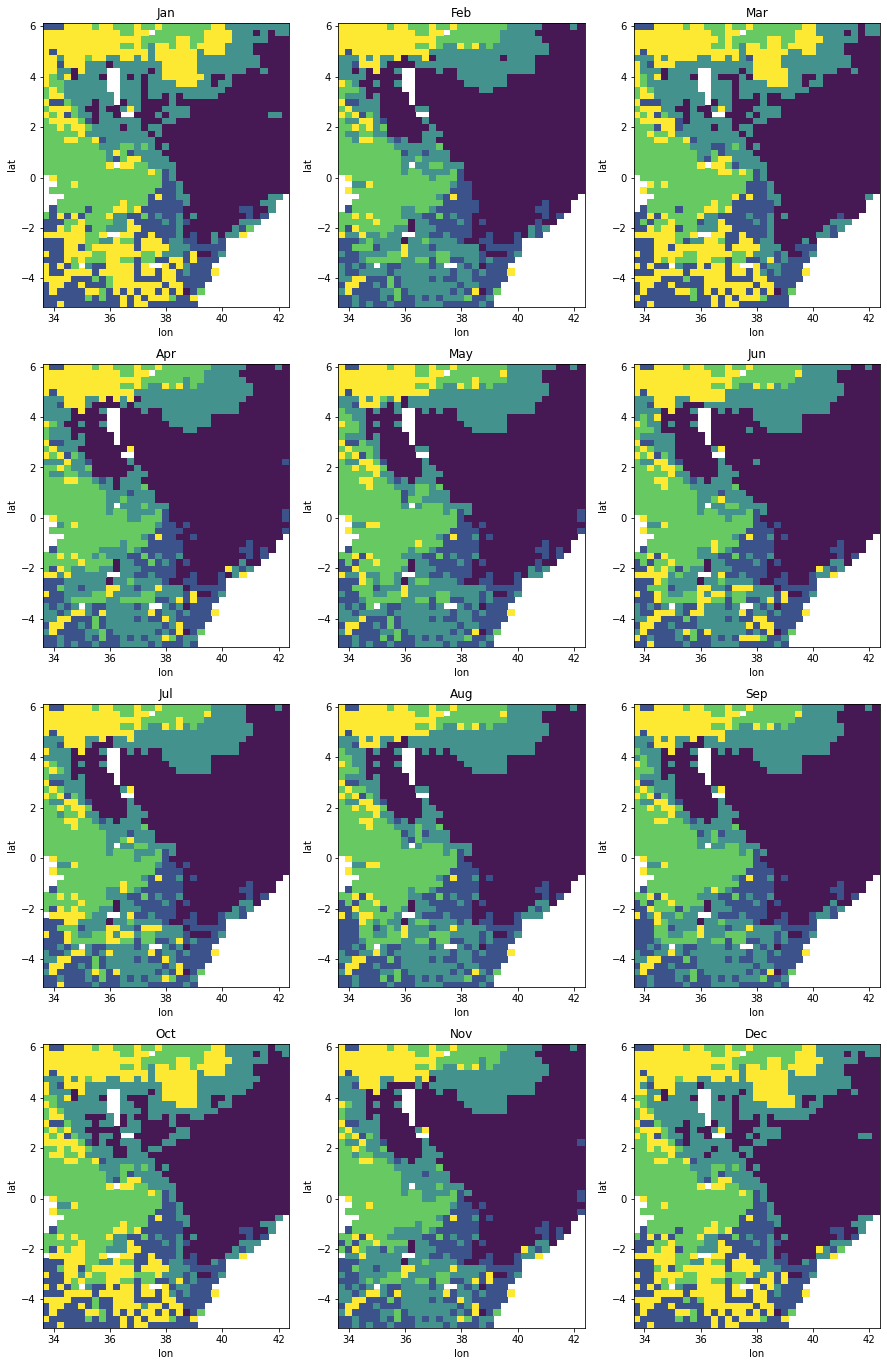

In [30]:
fig, axs = plt.subplots(4, 3, figsize=(15, 8*3))

cmap = ListedColormap(colors)

for mth in range(0, 12):
    ax = axs[np.unravel_index(mth, (4, 3))]
    remapped_ds.cluster_5.isel(time=mth).plot(
        add_colorbar=False, ax=ax, cmap=cmap
    )
    ax.set_title(calendar.month_abbr[mth+1])

In [31]:
mask = (ds.boku_VCI.isel(time=-1).isnull())
ds.where(~mask)

# static_ds

<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan

Text(0.5, 1.0, 'Potential Evaporation')

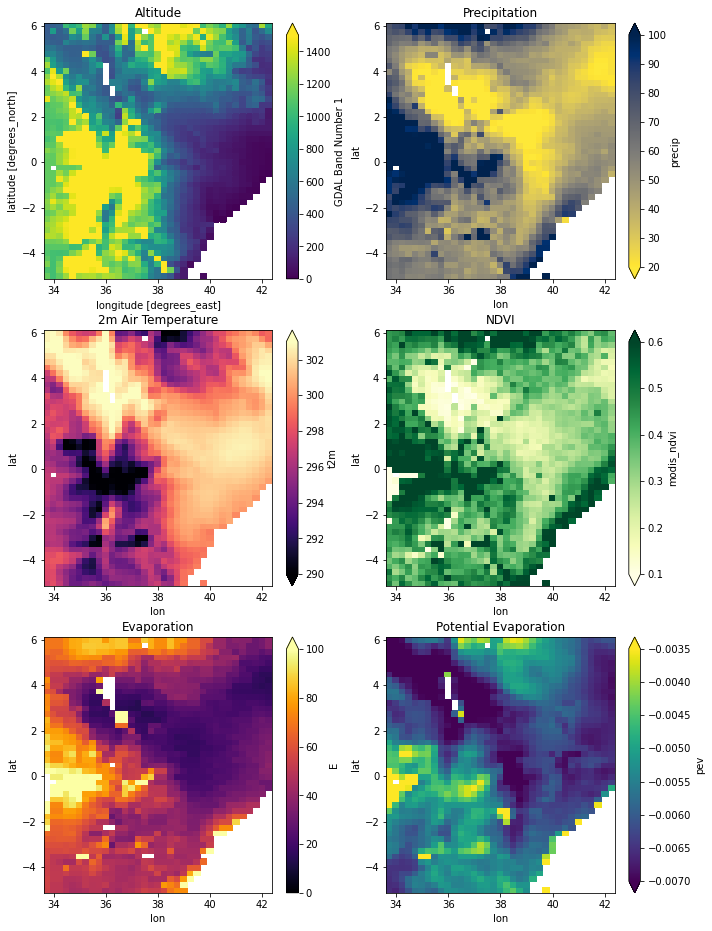

In [32]:
fig, axs = plt.subplots(3, 2, figsize=(3.75*3, 8*2))
static_ds.where(~mask).topography.plot(vmin=0, vmax=1500, ax=axs[0,0], cmap='viridis')
axs[0,0].set_title('Altitude')

ds.precip.where(~mask).mean(dim='time').plot(ax=axs[0,1], vmin=20, vmax=100, cmap='cividis_r')
axs[0,1].set_title('Precipitation')

ds.t2m.where(~mask).mean(dim='time').plot(ax=axs[1,0], vmin=290, vmax=303, cmap='magma')
axs[1,0].set_title('2m Air Temperature')

ds.modis_ndvi.where(~mask).mean(dim='time').plot(ax=axs[1,1], vmin=0.1, vmax=0.6, cmap='YlGn')
axs[1,1].set_title('NDVI')

ds.E.where(~mask).mean(dim='time').plot(ax=axs[2,0], vmin=0, vmax=100, cmap='inferno')
axs[2,0].set_title('Evaporation')

(
    ds.pev.mean(dim='time')
#     static_ds.cropland_irrigated_or_postflooding_one_hot + static_ds.cropland_rainfed_one_hot
).where(~mask).plot(vmin=-0.007, vmax=-0.0035, ax=axs[2,1], cmap='viridis')
axs[2,1].set_title('Potential Evaporation')
# axs[2,1].set_title('Cropland LC Boolean')

# interpret the different groups

In [33]:
from src.utils import create_shape_aligned_climatology

remapped_ds['month'] = remapped_ds['time'] + 1

variable = 'precip'
time_period = 'month'

dynamic_ds = ds.drop(ealstm.ignore_vars)
ds_clusters = create_shape_aligned_climatology(dynamic_ds, remapped_ds.rename({'cluster_5': 'precip'}), 'precip', 'month').rename({'precip': 'cluster_5'})
da_clusters = ds_clusters.cluster_5

display(ds_clusters)

<xarray.Dataset>
Dimensions:    (lat: 45, lon: 35, time: 205)
Coordinates:
  * lat        (lat) float64 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon        (lon) float64 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time       (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
Data variables:
    cluster_5  (time, lat, lon) float64 3.0 3.0 0.0 3.0 3.0 ... 2.0 2.0 2.0 2.0

In [34]:
region_codes = dict(zip([r.name for r in regions], [4, 1, 0, 3, 2]))
region_colors = dict(zip([r.name for r in regions], colors[[4, 1, 0, 3, 2]]))

coastal_ds = dynamic_ds.where(da_clusters == region_codes['coastal'])
coastal_ds

<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 205)
Coordinates:
  * time      (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat       (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.0 5.25 5.5 5.75 6.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI  (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    VCI3M     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    precip    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    E         (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SMroot    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    SMsurf    (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    pev       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    t2m       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    month     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [35]:
region_codes

{'coastal': 4, 'victoria': 1, 'nw_pastoral': 0, 'kitui': 3, 'turkana_edge': 2}

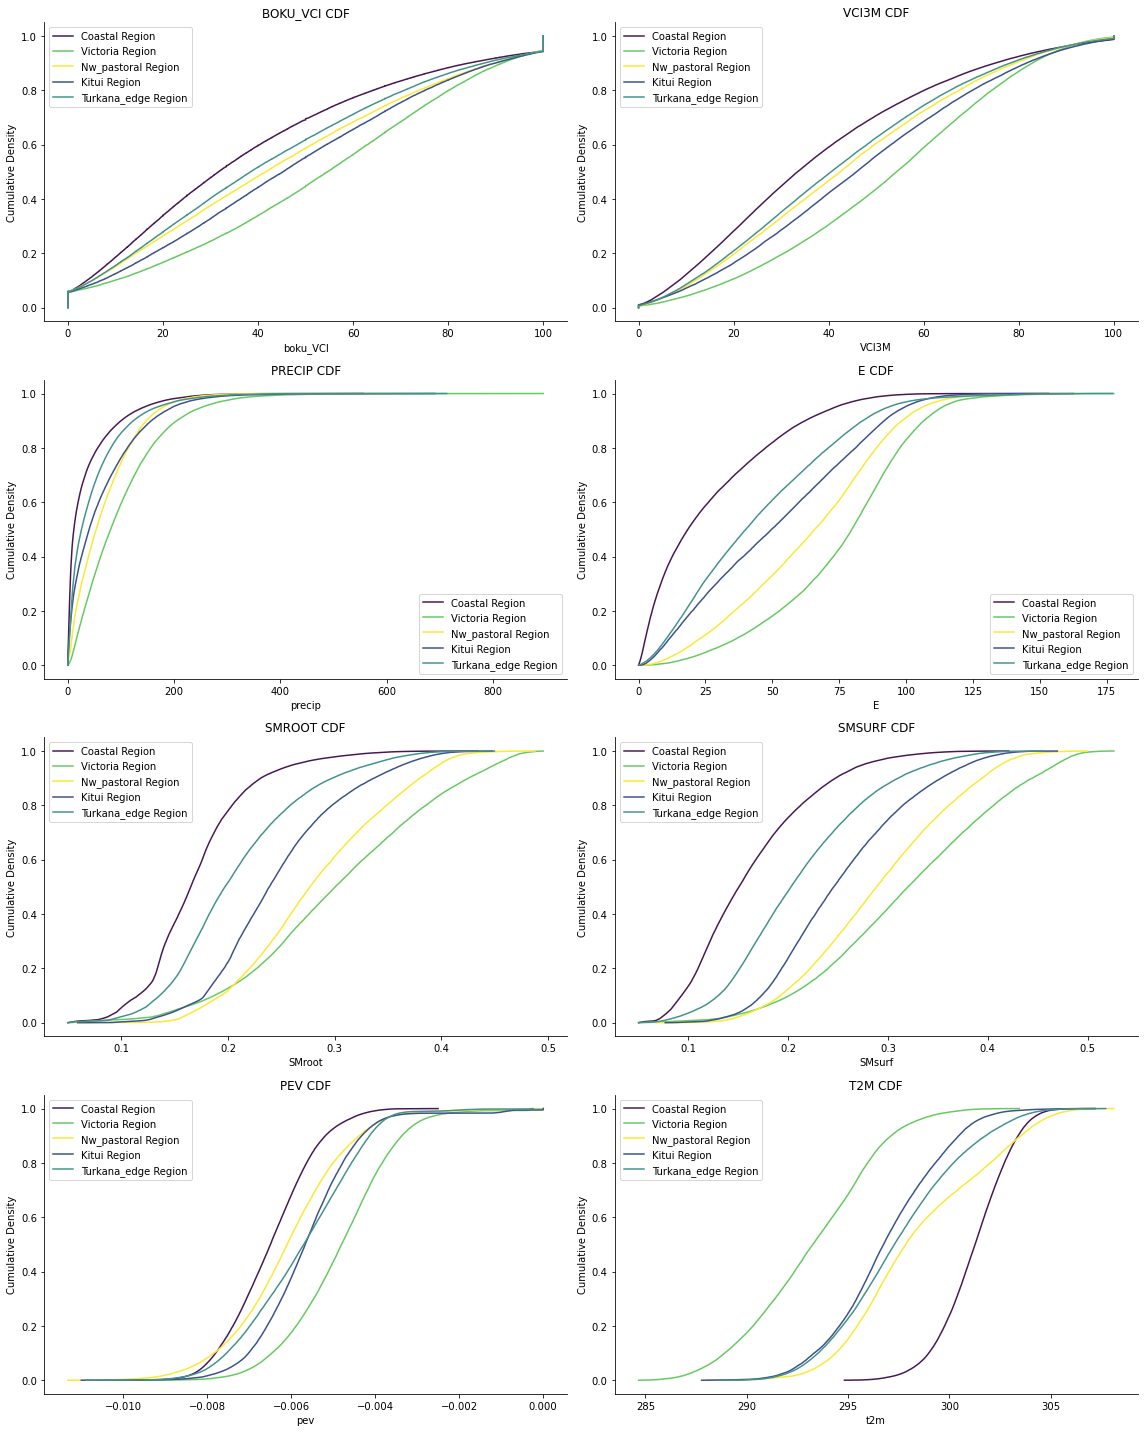

In [36]:
def plot_cdf(data: np.array, ax: Optional[plt.Axes] = None, **kwargs):
    """plot the sorted_data array against the number 
    of items smaller than each element in the array

    # https://stackoverflow.com/a/24576863/9940782
    """
    sorted_data = np.sort(data)
    
    # compute the 
    yvals = np.arange(len(sorted_data)) / (len(sorted_data) - 1)
    
    if ax is None:
        fig, ax = plt.subplots()
    ax.plot(sorted_data, yvals, **kwargs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend()
    
    return ax


fig, axs = plt.subplots(4, 2, figsize=(8*2, 5*4))
variable = 'precip'
ix = 0

for ix, variable in enumerate(list(dynamic_ds.drop(['month']).data_vars)):
    ax = axs[np.unravel_index(ix, (4, 2))]

    for region in [n for n in region_codes.keys()]:
        # Extract the pixels from those regions 
        # data = a 1D array of the values from ds (no-nans)
        data = drop_nans_and_flatten(
            dynamic_ds
            .where(
                da_clusters == region_codes[region]
            )[variable]
        )

        # plot cdf of the variable in that cluster
        ax = plot_cdf(
            data, ax=ax, 
            **dict(color=region_colors[region], label=f'{region.capitalize()} Region')
        )
        ax.set_xlabel(variable)
        ax.set_ylabel('Cumulative Density')
        ax.set_title(f'{variable.upper()} CDF')

plt.tight_layout()

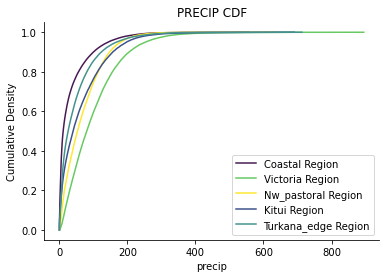

In [37]:
variable = 'precip'
ix = 0
fig, ax = plt.subplots()

for region in [n for n in region_codes.keys()]:
    # Extract the pixels from those regions 
    # data = a 1D array of the values from ds (no-nans)
    data = drop_nans_and_flatten(
        dynamic_ds
        .where(
            da_clusters == region_codes[region]
        )[variable]
    )

    # plot cdf of the variable in that cluster
    ax = plot_cdf(
        data, ax=ax, 
        **dict(color=region_colors[region], label=f'{region.capitalize()} Region')
    )
    ax.set_xlabel(variable)
    ax.set_ylabel('Cumulative Density')
    ax.set_title(f'{variable.upper()} CDF')

In [38]:
static_ds[[v for v in static_ds.data_vars if 'mean' not in v]]

<xarray.Dataset>
Dimensions:                                     (lat: 45, lon: 35)
Coordinates:
  * lat                                         (lat) float32 6.0 5.75 ... -5.0
  * lon                                         (lon) float32 33.75 ... 42.25
Data variables:
    topography                                  (lat, lon) float32 ...
    lc_class                                    (lat, lon) float64 ...
    lc_class_group                              (lat, lon) int64 ...
    no_data_one_hot                             (lat, lon) float64 ...
    cropland_rainfed_one_hot                    (lat, lon) float64 ...
    herbaceous_cover_one_hot                    (lat, lon) float64 ...
    tree_or_shrub_cover_one_hot                 (lat, lon) float64 ...
    cropland_irrigated_or_postflooding_one_hot  (lat, lon) float64 ...
    tree_cover_one_hot                          (lat, lon) float64 ...
    shrubland_one_hot                           (lat, lon) float64 ...
    grassland_one_hot                           (lat, lon) float64 ...
    lichens_and_mosses_one_hot                  (lat, lon) float64 ...
    urban_areas_one_hot                         (lat, lon) float64 ...
    bare_areas_one_hot                          (lat, lon) float64 ...
    water_bodies_one_hot                        (lat, lon) float64 ...
    permanent_snow_and_ice_one_hot              (lat, lon) float64 ...
    slt                                         (lat, lon) float64 ...

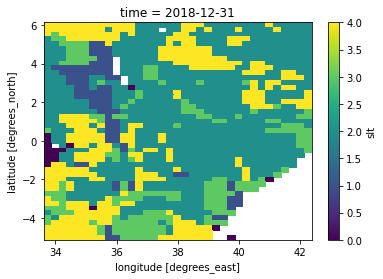

In [39]:
static_ds.slt.where(~mask).plot()

# Plot each region as one value (the mean) for that variable in that time-period
- 4x3 grid of the mean for each variable

--------------------------------------
--------------------------------------
--------------------------------------

# Explain Results

In [1]:
assert False, "DON'T WANT TO RUN THIS IN THE NOTEBOOK"

AssertionError: DON'T WANT TO RUN THIS IN THE NOTEBOOK

In [40]:
test_folders = [d for d in (data_dir / f'features/{EXPERIMENT}/test').iterdir()]
test_folders

[PosixPath('data/features/one_month_forecast/test/2016_4'),
 PosixPath('data/features/one_month_forecast/test/2016_5'),
 PosixPath('data/features/one_month_forecast/test/2017_11'),
 PosixPath('data/features/one_month_forecast/test/2018_1'),
 PosixPath('data/features/one_month_forecast/test/2017_12'),
 PosixPath('data/features/one_month_forecast/test/2018_7'),
 PosixPath('data/features/one_month_forecast/test/2018_9'),
 PosixPath('data/features/one_month_forecast/test/2016_1'),
 PosixPath('data/features/one_month_forecast/test/2017_6'),
 PosixPath('data/features/one_month_forecast/test/2016_7'),
 PosixPath('data/features/one_month_forecast/test/2018_10'),
 PosixPath('data/features/one_month_forecast/test/2018_8'),
 PosixPath('data/features/one_month_forecast/test/2017_3'),
 PosixPath('data/features/one_month_forecast/test/2017_1'),
 PosixPath('data/features/one_month_forecast/test/2017_4'),
 PosixPath('data/features/one_month_forecast/test/2018_11'),
 PosixPath('data/features/one_month_forecast/test/2016_6'),
 PosixPath('data/features/one_month_forecast/test/2016_8'),
 PosixPath('data/features/one_month_forecast/test/2018_4'),
 PosixPath('data/features/one_month_forecast/test/2018_5'),
 PosixPath('data/features/one_month_forecast/test/2016_2'),
 PosixPath('data/features/one_month_forecast/test/2017_7'),
 PosixPath('data/features/one_month_forecast/test/2016_9'),
 PosixPath('data/features/one_month_forecast/test/2017_5'),
 PosixPath('data/features/one_month_forecast/test/2017_8'),
 PosixPath('data/features/one_month_forecast/test/2016_10'),
 PosixPath('data/features/one_month_forecast/test/2016_12'),
 PosixPath('data/features/one_month_forecast/test/2018_12'),
 PosixPath('data/features/one_month_forecast/test/2017_9'),
 PosixPath('data/features/one_month_forecast/test/2016_3'),
 PosixPath('data/features/one_month_forecast/test/2018_6'),
 PosixPath('data/features/one_month_forecast/test/2018_3'),
 PosixPath('data/features/one_month_forecast/test/2017_10'),
 PosixPath('data/features/one_month_forecast/test/2016_11'),
 PosixPath('data/features/one_month_forecast/test/2017_2'),
 PosixPath('data/features/one_month_forecast/test/2018_2')]

In [41]:
test_folder = data_dir / f'features/{EXPERIMENT}/test/2018_3'
loader = ealstm.get_dataloader(
    data_path=data_dir,
    mode="test",
    batch_file_size=1,
    to_tensor=True,
    shuffle_data=False,
)
loader.data_files = [test_folder]
key, val = list(next(iter(loader)).items())[0]
num_pixels = val.x.historical.shape[0]
start_idx = 0
var_names = val.x_vars

In [42]:
len(val.latlons)
type(val)

src.models.data.ModelArrays

In [43]:
# explanations = ealstm.explain(
#     x=val.x,
#     var_names=var_names,
#     save_explanations=False,
#     background_size=100,
#     start_idx=start_idx,
#     num_inputs=num_pixels,
#     method='shap',
# )

Extracting a sample of the training data


KeyboardInterrupt: 

In [ ]:
dataloader = loader
shap_data = explanations
input_arrays = val
print(input_arrays.__dict__.keys())
print(shap_data.__dict__.keys())
display(dir(dataloader))

In [ ]:
latlons = input_arrays.latlons
times = np.array(input_arrays.historical_times)

dynamic_vars = input_arrays.x_vars
static_vars = list(dataloader.static.data_vars)

In [ ]:
from src.models.data import TrainData, ModelArrays, DataLoader
from src.models.neural_networks.base import NNBase


def _make_analysis_folder(model) -> Path:
    analysis_folder = model.model_dir / "analysis"
    if not analysis_folder.exists():
        analysis_folder.mkdir()
    return analysis_folder


def create_folder_date_str(ts: pd.Timestamp) -> str:
    return f"{ts.year}_{ts.month}"


def drop_vals(ds: xr.Dataset, ignore_vars: List[str]):
    ignore_vars = [
        v for v in ignore_vars 
        if v in [var_ for var_ in ds.data_vars]
    ]
    return ds.drop(ignore_vars)


def save_shap(dataloader: DataLoader, shap_data: TrainData, input_arrays: ModelArrays, model: NNBase) -> Tuple[xr.Dataset, xr.Dataset, xr.Dataset]:
    """Convert shap data in TrainData object to xarray objects"""
    # 1. get lats, lons, time
    latlons = input_arrays.latlons
    times = np.array(input_arrays.historical_times)
    target_time = input_arrays.target_time
    date_str = create_folder_date_str(target_time)
    
    # 2. get static_vars, dynamic_vars
    dynamic_vars = input_arrays.x_vars
    static_vars = list(dataloader.static.data_vars)
    
    # check that the shapes are correct
    assert shap_data.historical.shape == (len(latlons), len(times), len(dynamic_vars))
    assert shap_data.static.shape == (len(latlons), len(static_vars))

    # 3. calculate the xarray objects
    shap_historical_ds = dynamic_data_to_xarray(shap_data, latlons, var_names, times)
    shap_static = static_data_to_xarray(shap_data, latlons, static_vars)
    shap_pred_month = ohe_month_data_to_xarray(shap_data, latlons, static_vars)
    return_arrays = (shap_historical_ds, shap_static, shap_pred_month)

    # 4. save the xarray objects
    analysis_folder = _make_analysis_folder(model)
    shap_historical_ds.to_netcdf(analysis_folder / date_str / "shap_historical_ds.nc")
    shap_static.to_netcdf(analysis_folder / date_str / "shap_static.nc")
    shap_pred_month.to_netcdf(analysis_folder / date_str / "shap_pred_month.nc")
    
    return return_arrays
    

def run_shap(model: NNBase, input_arrays: ModelArrays, var_names: List[str], num_pixels: int, start_idx: int = 0) -> TrainData:
    """Explain the NN model using shap.DeepExplainer """
    explanations, baseline = model.explain(
        x=input_arrays.x,
        var_names=var_names,
        save_explanations=False,
        background_size=100,
        start_idx=start_idx,
        num_inputs=num_pixels,
        method='shap',
    )
    
    return explanations


def run_shap_for_folder(test_folder: Path, model: NNBase):
    """for the test_folder create .nc files 
    containing the shap values for the inputs to the model
    """
    
    # 1. get the Test data to run shap analysis
    loader = model.get_dataloader(
        data_path=data_dir,
        mode="test",
        batch_file_size=1,
        to_tensor=True,
        shuffle_data=False,
    )
    loader.data_files = [test_folder]
    key, input_arrays = list(next(iter(loader)).items())[0]
    num_pixels = input_arrays.x.historical.shape[0]
    start_idx = 0
    var_names = input_arrays.x_vars
    
    # 2. run shap
    explanations = run_shap(
        model=model, 
        input_arrays=input_arrays, 
        var_names=var_names, 
        num_pixels=num_pixels, 
        start_idx=start_idx
    )
    
    # 3. convert to xarray and save to .nc
    save_shap(
        dataloader=dataloader,
        shap_data=shap_data,
        input_arrays=input_arrays,
        model=model,
    )
    

def dynamic_data_to_xarray(shap_data: TrainData, latlons: np.ndarray, var_names: List[str], times: List[pd.Timestamp]) -> xr.Dataset:
    """convert numpy array of shape (latlons, time, n_features) to xarray
    """
    all_times = []
    for t_ix, time in enumerate(times):
        # pixel, [time], n_features
        array = shap_data.historical[:, t_ix, :]
        all_times.append(
            single_time_to_xarray(array, latlons, var_names, time=time)
        )
    shap_historical_ds = xr.combine_by_coords(all_times)
    return shap_historical_ds


def single_time_to_xarray(
    array: np.ndarray, 
    latlons: np.ndarray, 
    var_names: List[str], 
    time: pd.Timestamp
) -> xr.Dataset:
    """"""
    assert len(latlons) == array.shape[0]
    # create list of each variable
    all_dfs = [
        pd.DataFrame(
            data={
                var_name: array[:, var_ix],
                "lat": latlons[:, 0],
                "lon": latlons[:, 1],
                "time": [time for _ in range(len(latlons))],
            }
        ).set_index(['lat', 'lon', 'time'])
        for (var_ix, var_name) in enumerate(var_names)
    ]

    # join all variables together
    df = all_dfs[0]
    for d in all_dfs[1:]:
        df = df.join(d)

    return df.to_xarray()


def static_data_to_xarray(shap_data: TrainData, latlons: np.ndarray, var_names: List[str],) -> xr.Dataset:
    return pixel_data_to_xarray(shap_data.static, latlons, var_names)


def ohe_month_data_to_xarray(shap_data: TrainData, latlons: np.ndarray, var_names: List[str],) -> xr.Dataset:
    return pixel_data_to_xarray(shap_data.pred_months, latlons, var_names=[m for m in calendar.month_abbr if m != ''])


def pixel_data_to_xarray(
    array: np.ndarray, 
    latlons: np.ndarray, 
    var_names: List[str],
) -> xr.Dataset:
    """"""
    assert len(latlons) == array.shape[0]
    # create list of each variable
    all_dfs = [
        pd.DataFrame(
            data={
                var_name: array[:, var_ix],
                "lat": latlons[:, 0],
                "lon": latlons[:, 1],
            }
        ).set_index(['lat', 'lon'])
        for (var_ix, var_name) in enumerate(var_names)
    ]

    # join all variables together
    df = all_dfs[0]
    for d in all_dfs[1:]:
        df = df.join(d)

    return df.to_xarray()


shap_historical_ds = dynamic_data_to_xarray(shap_data, latlons, var_names, times)
shap_static = static_data_to_xarray(shap_data, latlons, static_vars)
shap_pred_month = ohe_month_data_to_xarray(shap_data, latlons, static_vars)

In [ ]:
from collections import namedtuple
from pandas.tseries.offsets import MonthEnd
def get_timestep_from_date_str(date_str) -> pd.Timestamp:
    return pd.to_datetime(date_str, format="%Y_%m") + MonthEnd()

analysis_dir = ealstm.model_dir / "analysis"
[d for d in (ealstm.model_dir / "analysis").iterdir()]

In [ ]:
model = ealstm
analysis_dir = model.model_dir / "analysis"
dirs = [
    d for d in (ealstm.model_dir / "analysis").iterdir()
    if len(list(d.glob('*.nc'))) > 0
]
dirs

In [ ]:
ShapValues = namedtuple('ShapValues', ['date_str', 'target_time', 'historical', 'pred_month', 'static'])

out_dict = {}
for shap_analysis_dir in dirs:
    shap = ShapValues(
        date_str=shap_analysis_dir.name,
        target_time=get_timestep_from_date_str(shap_analysis_dir.name),
        historical=xr.open_dataset(shap_analysis_dir / "shap_historical_ds.nc"),
        pred_month=xr.open_dataset(shap_analysis_dir / "shap_pred_month.nc"),
        static=xr.open_dataset(shap_analysis_dir / "shap_static.nc"),
    )
    out_dict[shap_analysis_dir.name] = shap

In [ ]:
# shap_historical_ds
# shap_data.static.shape
# shap_data.pred_months
# shap_pred_month
# shap_data.yearly_aggs.shape
# shap_data.__dict__.keys()

In [ ]:
time = pd.to_datetime(
    shap_historical_ds.isel(time=-1)[variable].time.values
)

dir(time)
time._date_repr

In [ ]:
variables = [
    'VCI3M',
    'boku_VCI',
    'precip',
    'E',
    'SMroot',
    'SMsurf',
    'pev',
    't2m',
]

def plot_shap_obs_pair(shap_ds: xr.Dataset, obs_ds: xr.Dataset, variables: List[str], shap_plot_kwargs: Dict, obs_plot_kwargs: Dict) -> None:
    n_variables = len(variables)
    assert np.unique(shap_ds.time.values) == 1, "Only works for a single time"
    fig, axs = plt.subplots(n_variables, 2, figsize=(6*2, 4*n_variables))
    
    for ix, variable in enumerate(variables):
        ax_row = axs[ix, :]
        # plot shap values
        shap_ds[variable].plot(ax=ax_row[0], cmap='RdBu', **shap_plot_kwargs)
        ax_row[0].set_title(f"{time._date_repr}: SHAP {variable}")

        # plot the observed data
        time = pd.to_datetime(
            shap_ds.time.values
        )
        obs_ds.sel(time=time)[variable].where(~mask).plot(ax=ax_row[1], **obs_plot_kwargs)
        ax_row[1].set_title(f"{time._date_repr}: RAW {variable}")
        
        for ax in ax_row:
            ax.axis('off')

        

fig, axs = plt.subplots(8, 2, figsize=(6*2, 4*8))
for ix, variable in enumerate(variables):
    ax_row = axs[ix, :]
    shap_historical_ds.isel(time=-1)[variable].plot(ax=ax_row[0], vmin=-0.4, vmax=0.4, cmap='RdBu')
    ax_row[0].set_title(f"{time._date_repr}: SHAP {variable}")
    time = pd.to_datetime(
        shap_historical_ds.isel(time=-1)[variable].time.values
    )
    if variable not in ["pev", "t2m"]:
        kwargs = dict(vmin=0)
    else:
        kwargs = dict(vmin=None, vmax=None)
    ds.sel(time=time)[variable].where(~mask).plot(ax=ax_row[1], **kwargs)
    ax_row[1].set_title(f"{time._date_repr}: RAW {variable}")
    
    for ax in ax_row:
        ax.axis('off')
        

In [ ]:
date_str = create_folder_date_str(target_time)

In [ ]:
target_time = input_arrays.target_time

In [ ]:
latlons = ds.stack(pixel=['lat', 'lon']).pixel.values
type(explanations)
dir(explanations)

In [ ]:
explanations.historical.shape

In [ ]:
# loader.static
fig, ax = plt.subplots()
img = ax.pcolor(explanations.pred_months, cmap='plasma')
plt.colorbar(img)
ax.set_title('Pred Month Array')
ax.set_xlabel('Feature')
ax.set_ylabel('Pixel')

# array = explanations.historical
# array = array.reshape(array.shape[0], -1)
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
for ix in range(explanations.historical.shape[1]):
    ax = axs[ix]
    array = explanations.historical[:, ix, :]
    img = ax.pcolor(array, cmap='plasma', vmax=0.6)
    if ix == 2:
        plt.colorbar(img)
    ax.set_title(f'Dynamic Array T-{3-ix}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Pixel')

array = explanations.static
# array = array.reshape(array.shape[0], -1)
fig, ax = plt.subplots()
img = ax.pcolor(array, vmin=0, cmap='plasma')
plt.colorbar(img)
ax.set_title('Static Array')
ax.set_xlabel('Feature')
ax.set_ylabel('Pixel')

array = explanations.prev_y_var
# array = array.reshape(array.shape[0], -1)
fig, ax = plt.subplots()
img = ax.pcolor(array, vmin=0, cmap='plasma')
plt.colorbar(img)
ax.set_title('Previous Y Array')
ax.set_xlabel('Feature')
ax.set_ylabel('Pixel')

In [ ]:
dims = ('time', 'lat', 'lon')
variable = var_names[0]
xr.Dataset(
    {
        variable: (dims, data)
        # for ix, variable in enumerate(var_names)
    },
    coords={'time': times, 'lat': lats, 'lon': lons},
)

# Morris Gradients

In [ ]:
from src.analysis import all_explanations_for_file

model = ealstm

In [ ]:
# all_explanations_for_file(
#     data_dir / f'features/{EXPERIMENT}/test/2018_3', ealstm, method='morris'
# )

In [ ]:
# ../../data/models/one_month_forecast/ealstm/analysis
[d.name for d in (ealstm.model_dir / "analysis").glob('*/*') if 'shap' in d.name]

In [ ]:
def get_fnames():
    files = [
#         'morris_value_yearly_aggs.npy',
#         'morris_value_pred_months.npy', 
        'morris_value_latlons.npy', 
        'morris_value_historical.npy', 
#         'morris_value_current.npy', 
        'morris_value_static.npy', 
        'morris_value_prev_y_var.npy'
    ]
    return files


def read_analysis(model) -> Dict[str, Dict[str, np.ndarray]]:
    out = {}
    dt_strings = [ts.name for ts in (model.model_dir / "analysis").iterdir()]
    files = get_fnames()
    
    for dt in dt_strings:
        out[dt] = {}
        
        analysis_dir = (model.model_dir / f"analysis/{dt}")
        
        # load in the forcing data
        out[dt]['forcing'] = pickle.load(open(analysis_dir / 'input_ModelArray.pkl', 'rb'))
        
        # load in the files
        for file in files:
            out[dt][file.replace('.npy', '')] = np.load(analysis_dir / file)
    
    return out

# Shap files

In [ ]:
from src.analysis import all_explanations_for_file

In [ ]:
# all_explanations_for_file(data_dir / f'features/{EXPERIMENT}/test/2018_3', ealstm)
model = ealstm
dt = [ts.name for ts in (model.model_dir / "analysis").iterdir()][0]

In [ ]:
# ../../data/models/one_month_forecast/ealstm/analysis
[d.name for d in (ealstm.model_dir / "analysis").glob('*/*')]

In [ ]:
def get_fnames():
    files = [
        'shap_value_yearly_aggs.npy', 
        'shap_value_pred_months.npy', 
        'shap_value_latlons.npy', 
        'shap_value_historical.npy', 
        'shap_value_current.npy', 
        'shap_value_static.npy', 
        'shap_value_prev_y_var.npy'
    ]
    return files


def read_analysis(model) -> Dict[str, Dict[str, np.ndarray]]:
    out = {}
    dt_strings = [ts.name for ts in (model.model_dir / "analysis").iterdir()]
    files = get_fnames()
    
    for dt in dt_strings:
        out[dt] = {}
        
        analysis_dir = (model.model_dir / f"analysis/{dt}")
        
        # load in the forcing data
        out[dt]['forcing'] = pickle.load(open(analysis_dir / 'input_ModelArray.pkl', 'rb'))
        
        # load in the files
        for file in files:
            out[dt][file.replace('.npy', '')] = np.load(analysis_dir / file)
    
    return out

In [ ]:
out = read_analysis(ealstm)
print(out['2018_3']['shap_value_historical'].shape)
print(out['2018_3']['shap_value_static'].shape)
print(out['2018_3']['forcing'].x.historical.shape)

In [ ]:
# loader.static
fig, ax = plt.subplots()
img = ax.pcolor(out['2018_3']['shap_value_static'], vmin=0, cmap='plasma')
plt.colorbar(img)
ax.set_title('Static Array')
ax.set_xlabel('Feature')
ax.set_ylabel('Pixel')

# array = explanations.historical
# array = array.reshape(array.shape[0], -1)
nrows = 1
ncols = 3
fig, axs = plt.subplots(nrows, ncols, figsize=(6*ncols, 4*nrows))
for ix in range(explanations.historical.shape[1]):
    ax = axs[ix]
    array = out['2018_3']['shap_value_historical'][:, ix, :]
    img = ax.pcolor(array, vmin=0, cmap='plasma', vmax=0.6)
    # plt.colorbar(img)
    ax.set_title(f'Dynamic Array T-{3-ix}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Pixel')


In [ ]:
out['2018_3'].keys()

In [ ]:
print("Static Shape:", out['2018_3']['forcing'].x.static.shape)

# NO aggregations in the data
print("N static vars:", len([i for i in static_ds.data_vars if "mean" not in i]), "+ 12 ohe months")

In [ ]:
out['2018_3']['shap_value_static'].shape

## Plot the mean shap values over all of first dimension

In [ ]:
array = out['2018_3']['shap_value_static']
means = []
for i in range(array.shape[-1]):
    means.append((array[:, i]).mean())

x = np.arange(len(means))
y = np.array(means)

fig, ax = plt.subplots(figsize=(10, 4))
ax.bar(x,y)
ax.set_xticks(x)
ax.set_xlabel('Array Feature')
ax.set_ylabel('Mean SHAP Value')
ax.set_title(f"Mean of each Feature Array\n${array.shape} => {y.shape}$")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
array = out['2018_3']['shap_value_historical']
print(array.shape)
array = array.reshape(array.shape[0], -1)
print(array.shape)

In [ ]:
array = out['2018_3']['shap_value_historical']
array = array.reshape(array.shape[0], -1)
assert len(array.shape) == 2

means = []
for i in range(array.shape[-1]):
    means.append(array[:, i].mean())

# make the plot
x = np.arange(len(means))
y = np.array(means)

fig, ax = plt.subplots(figsize=(10, 4))

for i in range(3):
    ax.bar(
        x=x[16*i:(16 * (i + 1))], 
        height=y[16*i:(16 * (i + 1))],
        label=f'Month t-{3-i}'
    )

ax.set_xticks(x)
ax.set_xticklabels(out['2018_3']['forcing'].x_vars * 3, rotation = 90)
ax.set_xlabel('Array Feature')
ax.set_ylabel('Mean SHAP Value')
ax.set_title(f"Mean of each Feature Array\n${array.shape} - {y.shape}$")
ax.legend(loc='lower left')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)